# With synthetic data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.model_selection import train_test_split
import pandas as pd

Importing data

In [ ]:
file_path = "CSV_FILES/Test256.xlsx"
df = pd.read_excel(file_path)
required_columns = [
    "Mass_Flow_kg_per_s",
    "Particle_Diameter_m",
    "Pressure_Drop_Pa",
    "Bed_Expansion_m",
]
if not all(col in df.columns for col in required_columns):
    raise ValueError(f"Excel file must contain columns: {required_columns}")

# Sorting the dataframe according to mass_flow_rate
df.sort_values(by="Mass_Flow_kg_per_s", inplace=True, ascending=True)

X = df[["Mass_Flow_kg_per_s", "Particle_Diameter_m"]].values
y = df[["Pressure_Drop_Pa", "Bed_Expansion_m"]].values

input_shape = (X.shape[-1],)
y.shape

(256, 2)

Normalizing input and outputs

In [3]:
mean_X = np.mean(X, axis=0)
std_X = np.std(X, axis=0)
X_scaled = (X - mean_X) / std_X

mean_y = np.mean(y, axis=0)
std_y = np.std(y, axis=0)
y_scaled = (y - mean_y) / std_y

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.9, random_state=42, shuffle=True
)

In [5]:
kernel = RBF(length_scale=1, length_scale_bounds=(1e-10, 1e10))

In [6]:
GP = GaussianProcessRegressor(
    kernel=kernel, n_restarts_optimizer=200, random_state=30, alpha=1e-5
)
GP.fit(X=X_train, y=y_train)

,kernel,RBF(length_scale=1)
,alpha,1e-05
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,200
,normalize_y,False
,copy_X_train,True
,n_targets,None
,random_state,30
,kernel__length_scale,1
,kernel__length_scale_bounds,"(1e-10, ...)"


In [7]:
def scaler(x, mean, stdev):
    return (x - mean) / stdev


def descaler(x_scaled, mean, stdev):
    return x_scaled * stdev + mean


def descaler_gp(output, mean, standard_deviation):
    y, stdy = output
    return y * standard_deviation + mean, stdy * standard_deviation

In [8]:
n_diameters_to_plot = 2


dp_values_m = np.linspace(
    df["Particle_Diameter_m"].min(),
    df["Particle_Diameter_m"].max(),
    n_diameters_to_plot,
)
mass_flow_range = np.linspace(
    start=0, stop=X[:, 0].max() + 0.75 * mean_X[0], num=X_train.shape[0]
)

(25, 2)
(25, 2)


Text(0, 0.5, 'Pressure Drop')

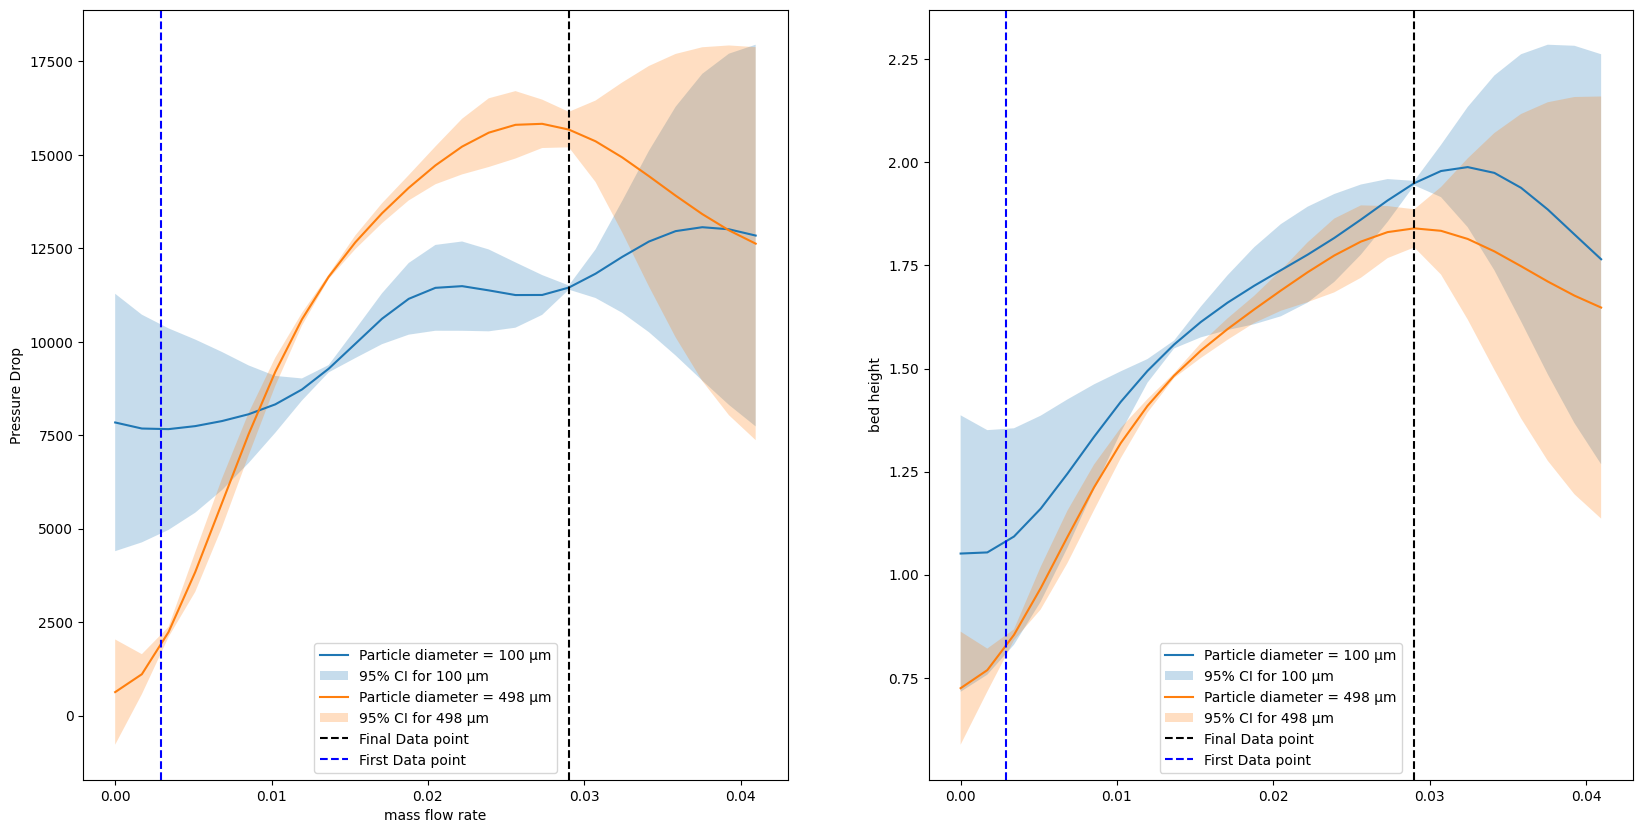

In [9]:
fig, chart = plt.subplots(1, 2)

for dp in dp_values_m:
    xdat = np.vstack([mass_flow_range, np.ones_like(mass_flow_range) * dp]).T
    print(xdat.shape)
    ydat, std_dat = descaler_gp(
        GP.predict(scaler(xdat, mean_X, std_X), return_std=True), mean_y, std_y
    )

    UQ_u = ydat + 1.96 * std_dat
    UQ_l = ydat - 1.96 * std_dat

    chart[0].plot(xdat[:, 0], ydat[:, 0], label=f"Particle diameter = {dp*1e6:.0f} µm")
    if n_diameters_to_plot <= 4:
        chart[0].fill_between(
            xdat[:, 0],
            UQ_u[:, 0],
            UQ_l[:, 0],
            alpha=0.25,
            label=f"95% CI for {dp*1e6:.0f} µm",
        )

    chart[1].plot(xdat[:, 0], ydat[:, 1], label=f"Particle diameter = {dp*1e6:.0f} µm")
    if n_diameters_to_plot <= 4:
        chart[1].fill_between(
            xdat[:, 0],
            UQ_u[:, 1],
            UQ_l[:, 1],
            alpha=0.25,
            label=f"95% CI for {dp*1e6:.0f} µm",
        )


fig.set_figheight(10)
fig.set_figwidth(20)

chart[0].axvline(X[:, 0].max(), label="Final Data point", linestyle="--", color="black")
chart[0].axvline(X[:, 0].min(), label="First Data point", linestyle="--", color="blue")

chart[1].axvline(X[:, 0].max(), label="Final Data point", linestyle="--", color="black")
chart[1].axvline(X[:, 0].min(), label="First Data point", linestyle="--", color="blue")
chart[0].legend()
chart[1].legend()
chart[0].set_xlabel("mass flow rate")
chart[0].set_xlabel("mass flow rate")
chart[1].set_ylabel("bed height")
chart[0].set_ylabel("Pressure Drop")

# With real data

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, Product
from sklearn.model_selection import train_test_split
import pandas as pd


def scaler(x, mean, stdev):
    return (x - mean) / stdev


def descaler(x_scaled, mean, stdev):
    return x_scaled * stdev + mean


def descaler_gp(output, mean, standard_deviation):
    y, stdy = output
    return y * standard_deviation + mean, stdy * standard_deviation


# Importing data
df = pd.read_csv("sand_data.csv")
df.sort_values(by="total_flowrate", inplace=True, ascending=True)
X = df[["fl_L1", "fl_L2", "initial_bed_height"]].values
y = df[["p1", "total_bed_height"]].values

# normalizing inputs
mean_X = np.mean(X, axis=0)
std_X = np.std(X, axis=0)
X_scaled = (X - mean_X) / std_X
mean_y = np.mean(y, axis=0)
std_y = np.std(y, axis=0)
y_scaled = (y - mean_y) / std_y


# splitting data and shuffling
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.01, random_state=42, shuffle=True
)


# building model
kernel = RBF(length_scale_bounds=(1e-16, 1e15)) + Product(
    WhiteKernel(noise_level_bounds=(1e-12, 1e15)),
    ConstantKernel(constant_value_bounds=(1e-20, 1e20)),
)
GP = GaussianProcessRegressor(
    kernel=kernel, n_restarts_optimizer=200, alpha=1e-10, random_state=30
)

# fitting model
GP.fit(X=X_train, y=y_train)

,kernel,RBF(length_sc...evel=1) * 1**2
,alpha,1e-10
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,200
,normalize_y,False
,copy_X_train,True
,n_targets,None
,random_state,30
,kernel__k1,RBF(length_scale=1)
,kernel__k2,WhiteKernel(n...evel=1) * 1**2
,kernel__k1__length_scale,1.0


In [121]:
GP.kernel_

RBF(length_scale=1.24) + WhiteKernel(noise_level=0.000124) * 31.3**2

In [ ]:
import joblib

joblib.dump(GP, "gp_with_bed.pkl")

['gp_with_bed.pkl']

In [123]:
pd.unique(df["initial_bed_height"].sort_values().values)

array([0.681, 0.681, 0.681, 0.739, 0.739, 0.739, 0.751, 0.751, 0.751,
       0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.889, 0.889, 0.889,
       0.903, 0.903, 0.923, 0.923, 0.93 , 0.93 , 0.942])

In [124]:
df["flowrate_combi"].max()

np.float64(1244.976751662753)

In [215]:
from helpers import processing

# checking = processing.read_and_process_data(
#     "good_data/sand/956_40_120_50_forward.xlsx", isexcel=True
# )
checking = processing.read_and_process_data("808.csv", isexcel=False)
initbed = 0.808
fre = 15
stepfl = 10
stepdur = 30

metrics = processing.filter(
    processing.calculate_metrics(checking, initbed, "sand", stepfl), fre
)

segments = processing.recover_averaged_data(
    metrics,
    fre,
    stepfl,
    stepdur,
    ["fl_L1", "fl_L2", "flowrate_combi", "p1", "total_bed_height"],
    initbed,
)

In [216]:
len(segments)

114

In [217]:
# plotting
n_bed_heights = 1
L2 = 1
bed_values = [0.808]
num_pred = 700
flowrate_range = np.vstack(
    [
        np.linspace(0, 600, num_pred).ravel(),
        np.linspace(0, 600, num_pred).ravel() * L2,
    ]
).T

additional = np.vstack(
    [np.linspace(600, 1000, 300).ravel(), np.ones(300).ravel() * 600 * L2]
).T

flowrate_range = np.vstack([flowrate_range, additional])

print("flowarate range shape = ", flowrate_range.shape)

flowarate range shape =  (1000, 2)


(1000, 3)


Text(0.5, 1.0, 'Total bed height UQ for 0.956 LPM')

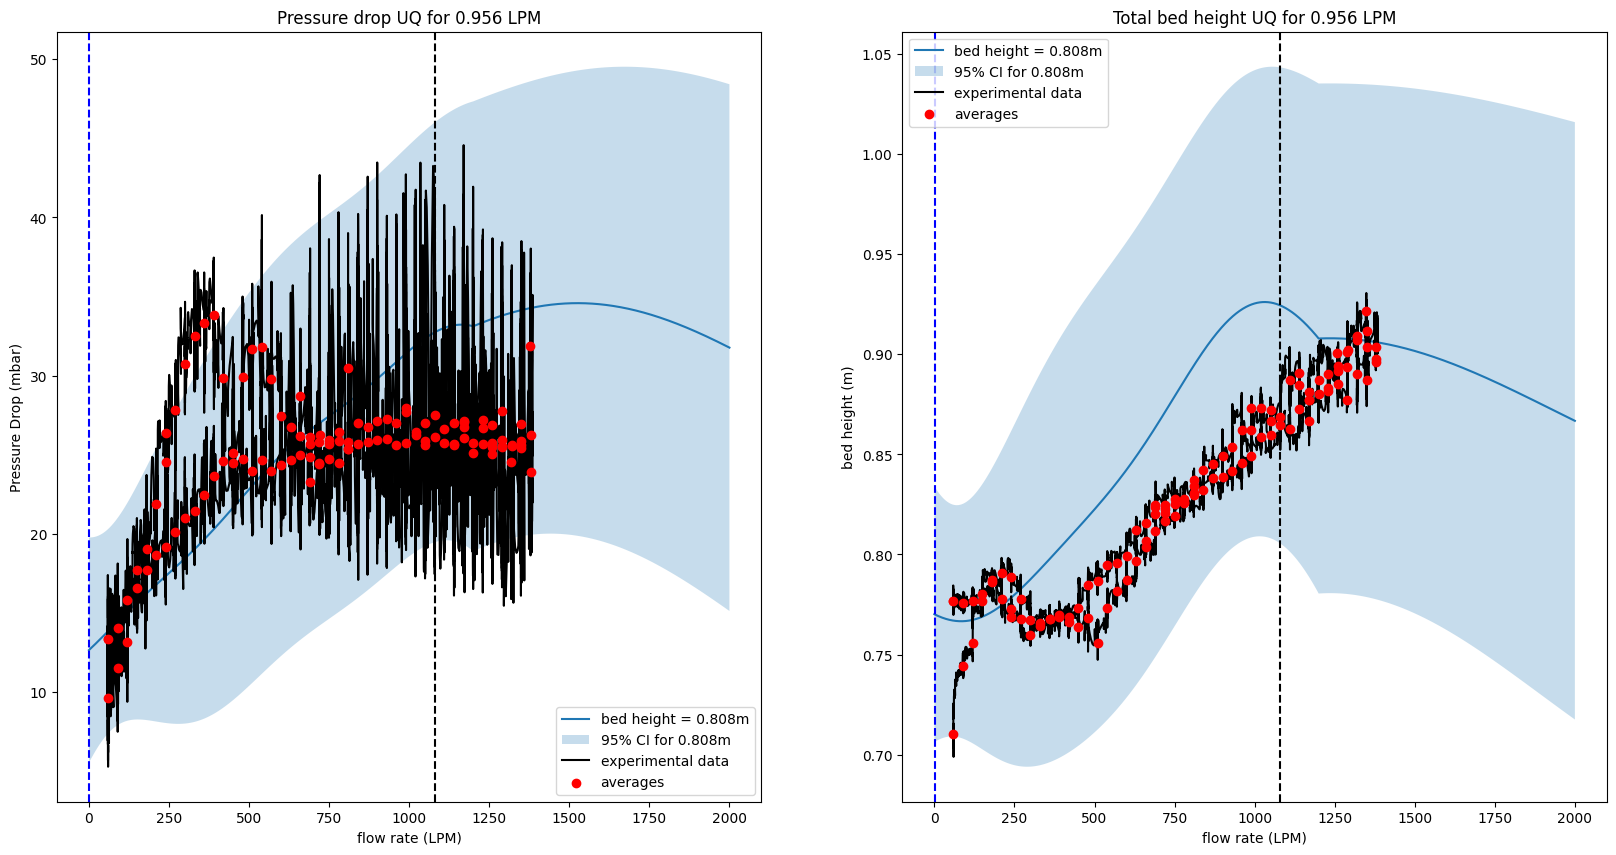

In [218]:
fig, chart = plt.subplots(1, 2)

for dp in bed_values:
    xdat = np.hstack(
        [flowrate_range, np.ones(num_pred + 300).reshape(num_pred + 300, 1) * dp]
    )
    print(xdat.shape)
    ydat, std_dat = descaler_gp(
        GP.predict(scaler(xdat, mean_X, std_X), return_std=True), mean_y, std_y
    )

    UQ_u = ydat + 1.96 * std_dat
    UQ_l = ydat - 1.96 * std_dat

    chart[0].plot(2 * xdat[:, 0], ydat[:, 0], label=f"bed height = {dp}m")
    if n_bed_heights <= 4:
        chart[0].fill_between(
            2 * xdat[:, 0],
            UQ_u[:, 0],
            UQ_l[:, 0],
            alpha=0.25,
            label=f"95% CI for {dp}m",
        )

    chart[1].plot(2 * xdat[:, 0], ydat[:, 1], label=f"bed height = {dp}m")
    if n_bed_heights <= 4:
        chart[1].fill_between(
            2 * xdat[:, 0],
            UQ_u[:, 1],
            UQ_l[:, 1],
            alpha=0.25,
            label=f"95% CI for {dp}m",
        )

# xdat = np.vstack([flowrate_range, np.ones_like(flowrate_range) * 0.8]).T
# ydat, std_dat = descaler_gp(
#     GP.predict(scaler(xdat, mean_X, std_X), return_std=True), mean_y, std_y
# )

# chart[0].plot(xdat[:, 0], ydat[:, 0], label=f"bed height = {0.8}m")
# chart[1].plot(xdat[:, 0], ydat[:, 1], label=f"bed height = {0.8}m")

# chart[0].scatter(
#     descaler(X_test, mean_X, std_X)[:, 0],
#     descaler(y_test, mean_y, std_y)[:, 0],
#     c="lime",
#     s=5,
# )

chart[0].plot(
    metrics["flowrate_combi"], metrics["p1"], color="black", label="experimental data"
)
chart[1].plot(
    metrics["flowrate_combi"],
    metrics["total_bed_height"],
    color="black",
    label="experimental data",
)

for seg in segments:
    chart[0].scatter(seg["flowrate_combi"], seg["p1"], c="red", zorder=3)
    chart[1].scatter(seg["flowrate_combi"], seg["total_bed_height"], c="red", zorder=3)

chart[0].scatter(
    segments[0]["flowrate_combi"],
    segments[0]["p1"],
    c="red",
    label="averages",
)
chart[1].scatter(
    segments[0]["flowrate_combi"],
    segments[0]["total_bed_height"],
    c="red",
    label="averages",
)

fig.set_figheight(10)
fig.set_figwidth(20)

chart[0].axvline(X[:, 0].max(), linestyle="--", color="black")
chart[0].axvline(X[:, 0].min(), linestyle="--", color="blue")

chart[1].axvline(X[:, 0].max(), linestyle="--", color="black")
chart[1].axvline(X[:, 0].min(), linestyle="--", color="blue")
chart[0].legend()
chart[1].legend()
chart[0].set_xlabel("flow rate (LPM)")
chart[1].set_xlabel("flow rate (LPM)")
chart[1].set_ylabel("bed height (m)")
chart[0].set_ylabel("Pressure Drop (mbar)")

chart[0].set_title("Pressure drop UQ for 0.956 LPM")
chart[1].set_title("Total bed height UQ for 0.956 LPM")

In [219]:
GP_nobed = joblib.load("gp_without_bed.pkl")

In [220]:
y1 = np.zeros((len(segments), 2))
y2 = np.zeros(len(segments))
std1 = np.zeros((len(segments), 2))
std2 = np.zeros_like(y2)
flowrates = np.zeros(len(segments))

for seg, i in zip(segments, range(len(segments))):
    flowrates[i] = seg["fl_L1"].values + seg["fl_L2"].values
    y1[i, :], std1[i, :] = descaler_gp(
        GP.predict(
            scaler(seg[["fl_L1", "fl_L2", "initial_bed_height"]].values, mean_X, std_X),
            return_std=True,
        ),
        mean_y,
        std_y,
    )
    y2[i], std2[i] = descaler_gp(
        GP_nobed.predict(
            scaler(seg[["fl_L1", "fl_L2", "initial_bed_height"]].values, mean_X, std_X),
            return_std=True,
        ),
        mean_y[0],
        std_y[0],
    )

C:\Users\Debangshu\AppData\Local\Temp\ipykernel_27032\601853793.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  flowrates[i] = seg["fl_L1"].values + seg["fl_L2"].values
C:\Users\Debangshu\AppData\Local\Temp\ipykernel_27032\601853793.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y2[i], std2[i] = descaler_gp(
C:\Users\Debangshu\AppData\Local\Temp\ipykernel_27032\601853793.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  flowrates[i] = seg["fl_L1"].value

In [221]:
y2.shape

(114,)

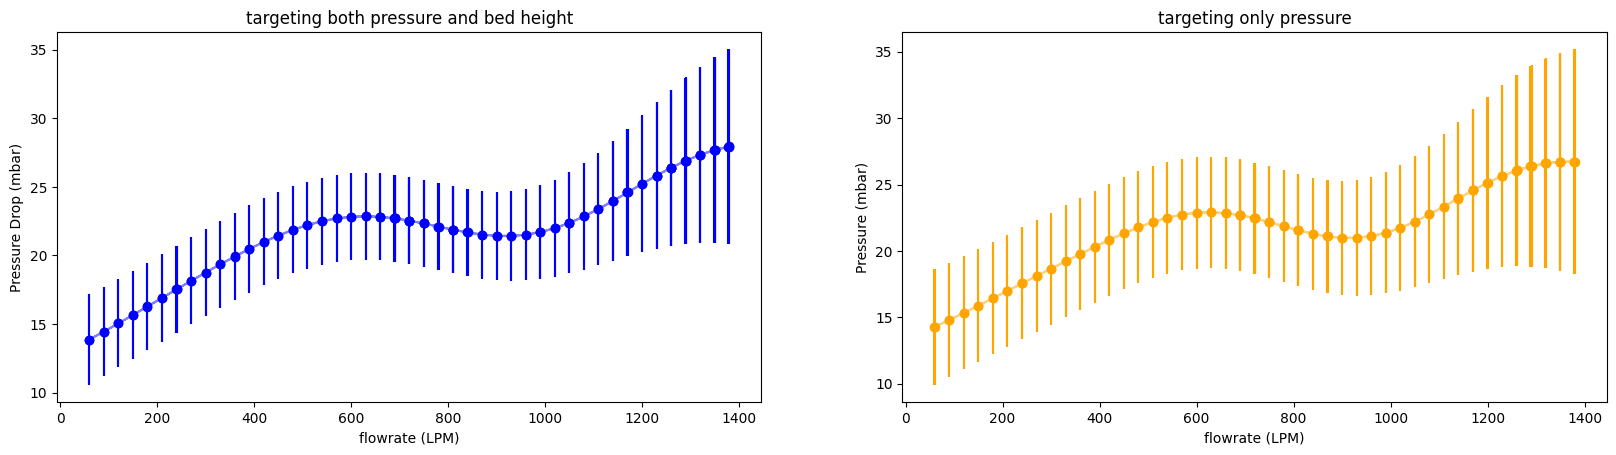

In [222]:
figg, compare = plt.subplots(1, 2)

compare[0].plot(flowrates, y1[:, 0], linestyle="-", color="blue", alpha=0.5)
# compare[0].scatter(flowrates, y1[:,0], c='blue')
compare[1].plot(flowrates, y2, linestyle="-", color="orange", alpha=0.5)
# compare[0].scatter(flowrates, y2, linestyle='-', color='orange')
compare[0].set_xlabel("flowrate (LPM)")
compare[0].set_ylabel("Pressure Drop (mbar)")
compare[1].set_xlabel("flowrate (LPM)")
compare[1].set_ylabel("Pressure (mbar)")
compare[0].errorbar(
    flowrates, y1[:, 0], std1[:, 0], fmt="o", linestyle="none", color="blue"
)
compare[1].errorbar(flowrates, y2, std2, fmt="o", linestyle="none", color="orange")
compare[0].set_title("targeting both pressure and bed height")
compare[1].set_title("targeting only pressure")
figg.set_figwidth(20)

In [223]:
from sklearn.preprocessing import StandardScaler

In [224]:
df = pd.read_csv("sand_data.csv")
df.sort_values(by="total_flowrate", inplace=True, ascending=True)
X = df[["fl_L1", "fl_L2"]].values
y = (df["total_bed_height"] - df["initial_bed_height"]).values

In [225]:
scalerx = StandardScaler()

Xscaled = scalerx.fit_transform(X)

GP_bed = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=200,
    alpha=1e-10,
    random_state=30,
    normalize_y=True,
)

GP_bed.fit(Xscaled, y)

,kernel,RBF(length_sc...evel=1) * 1**2
,alpha,1e-10
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,200
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,30
,kernel__k1,RBF(length_scale=1)
,kernel__k2,WhiteKernel(n...evel=1) * 1**2
,kernel__k1__length_scale,1.0


(1000, 3)


Text(0.5, 1.0, 'Total bed height UQ for 0.808 LPM')

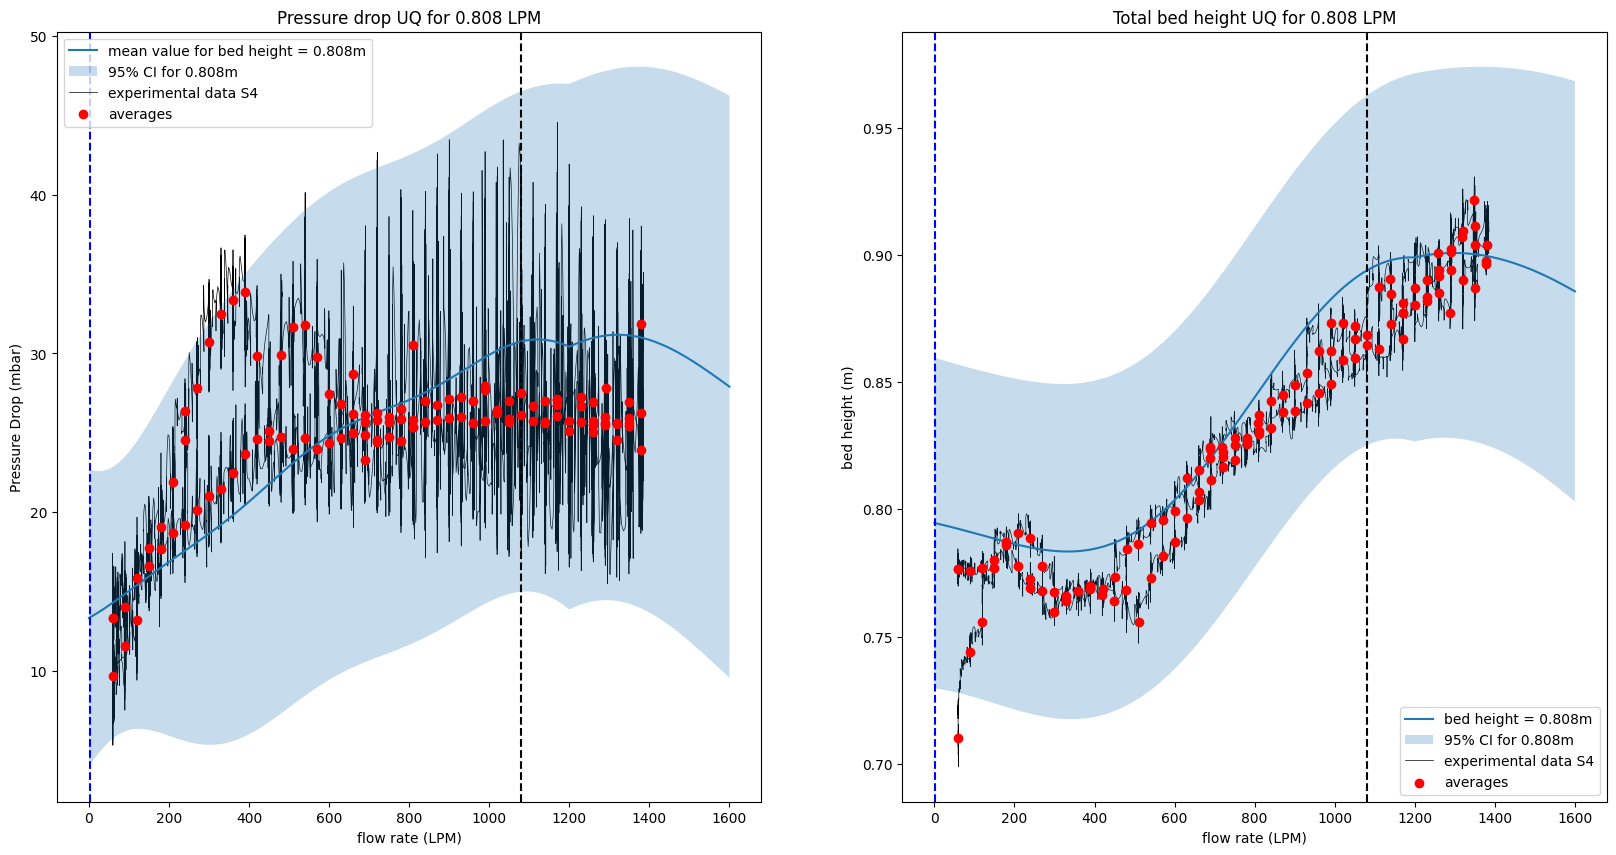

In [228]:
fig, chart = plt.subplots(1, 2)
bed_values = [0.808]

for dp in bed_values:
    xdat = np.hstack(
        [flowrate_range, np.ones(num_pred + 300).reshape(num_pred + 300, 1) * dp]
    )
    print(xdat.shape)
    ydat, std_dat = descaler_gp(
        GP_nobed.predict(scaler(xdat, mean_X, std_X), return_std=True),
        mean_y[0],
        std_y[0],
    )

    UQ_u = ydat + 1.96 * std_dat
    UQ_l = ydat - 1.96 * std_dat

    chart[0].plot(
        xdat[:, 0] + xdat[:, 1], ydat, label=f"mean value for bed height = {dp}m"
    )
    if n_bed_heights <= 4:
        chart[0].fill_between(
            xdat[:, 0] + xdat[:, 1],
            UQ_u,
            UQ_l,
            alpha=0.25,
            label=f"95% CI for {dp}m",
        )

    ybed, std_bed = GP_bed.predict(scalerx.transform(xdat[:, :-1]), return_std=True)
    uqbedu = ybed + 1.96 * std_bed + 0.808
    uqbedl = ybed - 1.96 * std_bed + 0.808

    chart[1].plot(xdat[:, 0] + xdat[:, 1], ybed + 0.808, label=f"bed height = {dp}m")
    if n_bed_heights <= 4:
        chart[1].fill_between(
            xdat[:, 0] + xdat[:, 1],
            uqbedu,
            uqbedl,
            alpha=0.25,
            label=f"95% CI for {dp}m",
        )

chart[0].plot(
    metrics["flowrate_combi"],
    metrics["p1"],
    color="black",
    label="experimental data S4",
    linewidth=0.5,
    zorder=0,
)
chart[1].plot(
    metrics["flowrate_combi"],
    metrics["total_bed_height"],
    color="black",
    label="experimental data S4",
    linewidth=0.5,
    zorder=0,
)

for seg in segments:
    chart[0].scatter(seg["flowrate_combi"], seg["p1"], c="red", zorder=3)
    chart[1].scatter(seg["flowrate_combi"], seg["total_bed_height"], c="red", zorder=3)

chart[0].scatter(
    segments[0]["flowrate_combi"],
    segments[0]["p1"],
    c="red",
    label="averages",
)
chart[1].scatter(
    segments[0]["flowrate_combi"],
    segments[0]["total_bed_height"],
    c="red",
    label="averages",
)

fig.set_figheight(10)
fig.set_figwidth(20)

chart[0].axvline(X[:, 0].max(), linestyle="--", color="black")
chart[0].axvline(X[:, 0].min(), linestyle="--", color="blue")

chart[1].axvline(X[:, 0].max(), linestyle="--", color="black")
chart[1].axvline(X[:, 0].min(), linestyle="--", color="blue")
chart[0].legend()
chart[1].legend()
chart[0].set_xlabel("flow rate (LPM)")
chart[1].set_xlabel("flow rate (LPM)")
chart[1].set_ylabel("bed height (m)")
chart[0].set_ylabel("Pressure Drop (mbar)")

chart[0].set_title("Pressure drop UQ for 0.808 LPM")
chart[1].set_title("Total bed height UQ for 0.808 LPM")